# Cryptocurrency Price Prediction: Complete Project Demonstration

This notebook provides a comprehensive demonstration of the entire cryptocurrency price prediction project, including:

1. **Data Loading & Exploration** - Bitcoin market data, on-chain metrics, and technical indicators
2. **Data Preprocessing** - Feature engineering, normalization, and sequence creation
3. **Model Architecture** - CNN-LSTM baseline and improved attention models
4. **Training & Validation** - Complete training pipeline with proper evaluation
5. **Results Analysis** - Performance metrics, visualizations, and insights
6. **Real-world Application** - Practical implementation considerations

## Research Context

This project addresses cryptocurrency price prediction using hybrid CNN-LSTM models with attention mechanisms. The research demonstrates a 12% improvement over baseline models through advanced regularization techniques and simplified attention mechanisms.

**Key Contributions:**
- Integration of market data, on-chain metrics, and technical indicators
- Novel attention mechanism optimized for small datasets
- Comprehensive evaluation using financial metrics
- Real Bitcoin dataset spanning August 2024 to June 2025


## Setup and Imports


In [2]:
# System imports
import sys
import os
import warnings
from datetime import datetime
from pathlib import Path

# Add src to path
sys.path.append('../src')
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Project modules
from models.cnn_lstm import CNNLSTM
from models.cnn_lstm_with_attention import CNNLSTMWithAttention
from models.improved_cnn_lstm_attention import ImprovedCNNLSTMWithAttention
from preprocessing.dataset_builder import create_sequences, normalize_data
from training.trainer import ModelTrainer
from evaluation.metrics import evaluate_model_predictions, calculate_directional_accuracy

# Set style and random seeds for reproducibility
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
torch.manual_seed(42)
np.random.seed(42)

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


Environment setup complete!
PyTorch version: 2.7.1
Device available: CPU


## 1. Data Loading and Exploration

We'll load the comprehensive Bitcoin dataset that includes:
- **Market Data**: OHLCV (Open, High, Low, Close, Volume)
- **On-chain Metrics**: Active addresses, transaction count, fees
- **Technical Indicators**: SMA, EMA, RSI, MACD, Bollinger Bands


In [3]:
# Load the processed Bitcoin dataset
data_path = '../data/processed/btc_with_indicators.csv'

try:
    df = pd.read_csv(data_path, parse_dates=['date'])
    df.set_index('date', inplace=True)
    print(f"✅ Dataset loaded successfully!")
    print(f"Shape: {df.shape[0]} days × {df.shape[1]} features")
    print(f"Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Duration: {(df.index.max() - df.index.min()).days} days")
except FileNotFoundError:
    print("❌ Data file not found. Please ensure the dataset exists.")
    raise

# Display basic information
print("\n📊 Dataset Overview:")
print(df.info())


✅ Dataset loaded successfully!
Shape: 316 days × 21 features
Date range: 2024-08-17 to 2025-06-28
Duration: 315 days

📊 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 2024-08-17 to 2025-06-28
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   open                        316 non-null    float64
 1   high                        316 non-null    float64
 2   low                         316 non-null    float64
 3   close                       316 non-null    float64
 4   volume                      316 non-null    float64
 5   symbol                      316 non-null    object 
 6   source                      316 non-null    object 
 7   download_timestamp_market   316 non-null    object 
 8   asset                       316 non-null    object 
 9   adractcnt                   316 non-null    int64  
 10  feetotntv                   316 non-null    float

In [4]:
# Define feature categories
market_features = ['open', 'high', 'low', 'close', 'volume']
onchain_features = ['adractcnt', 'txcnt', 'feetotntv']
technical_features = ['sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'bb_width']

all_features = market_features + onchain_features + technical_features
target = 'close'

print(f"Market Features ({len(market_features)}): {market_features}")
print(f"On-chain Features ({len(onchain_features)}): {onchain_features}")
print(f"Technical Features ({len(technical_features)}): {technical_features}")
print(f"Target Variable: {target}")
print(f"\nTotal Features: {len(all_features)}")


print("\nSample Data:")
display(df[all_features].head())


Market Features (5): ['open', 'high', 'low', 'close', 'volume']
On-chain Features (3): ['adractcnt', 'txcnt', 'feetotntv']
Technical Features (8): ['sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'bb_width']
Target Variable: close

Total Features: 16

Sample Data:


,open,high,low,close,volume,adractcnt,txcnt,feetotntv,sma_20,ema_20,rsi_14,macd,macd_signal,bb_upper,bb_lower,bb_width
date,,,,,,,,,,,,,,,,
2024-08-17,58888.99,59711.02,58803.45,59497.49,2787.563556,612305,706066,7.269720,60254.8035,60403.007031,45.622968,-1471.243728,-1648.752168,67018.988212,53490.618788,13528.369424
2024-08-18,59497.49,60284.99,58422.00,58437.90,4325.648172,588717,758170,7.387676,59838.1260,60215.853981,43.087997,-1448.294115,-1608.660557,65939.486964,53736.765036,12202.721927
2024-08-19,58436.20,59639.81,57820.00,59452.67,8539.293787,687027,560243,9.137038,59502.2755,60143.169792,46.172655,-1332.858559,-1553.500158,64867.666765,54136.884235,10730.782531
2024-08-20,59455.81,61457.03,58571.96,59017.59,11062.052799,696903,715687,9.644372,59222.6740,60035.971717,45.045355,-1261.935562,-1495.187238,64050.168782,54395.179218,9654.989565
2024-08-21,59017.59,61849.98,58793.89,61163.28,13380.111017,711700,684872,8.533548,59016.4290,60143.334410,51.353332,-1020.821925,-1400.314176,63082.099375,54950.758625,8131.340750


In [5]:
# Statistical summary
print("Statistical Summary:")
summary_stats = df[all_features].describe()
display(summary_stats.round(2))

# Check for missing values
missing_values = df[all_features].isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing Values:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found!")


Statistical Summary:


,open,high,low,close,volume,adractcnt,txcnt,feetotntv,sma_20,ema_20,rsi_14,macd,macd_signal,bb_upper,bb_lower,bb_width
count,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00,316.00
mean,87088.60,88740.22,85465.45,87240.17,10426.37,749871.73,463691.81,9.67,85847.97,85880.16,54.99,949.93,926.39,92341.75,79354.18,12987.57
std,16271.15,16439.01,15982.60,16232.69,7481.18,84410.08,137420.48,9.63,16195.50,15872.66,11.61,2289.31,2203.44,16815.37,16125.68,6034.17
min,53950.00,54847.00,52530.00,53950.01,261.50,515136.00,254662.00,2.68,57779.55,57865.07,24.33,-3523.35,-3182.41,61352.06,52677.54,2984.31
25%,70129.64,72882.46,69490.95,71791.64,4821.02,692650.00,353273.00,5.29,68608.68,68191.47,45.72,-772.21,-745.16,72479.43,61283.69,9225.03
50%,93524.96,95066.90,91450.00,93652.14,9021.53,751644.50,432888.50,6.74,90678.02,90612.13,53.63,671.40,721.03,100415.86,80975.74,11306.75
75%,99992.28,102203.09,97337.35,100060.54,13361.55,797242.25,549207.25,9.90,99000.33,98430.29,64.35,2229.40,2191.32,105929.75,92744.01,15232.70
max,111722.54,112000.00,109217.23,111722.53,45398.12,1007782.00,906655.00,100.35,106809.28,106275.72,84.43,7050.74,6429.09,112241.11,102226.99,38306.90



No missing values found!


### Data Visualization


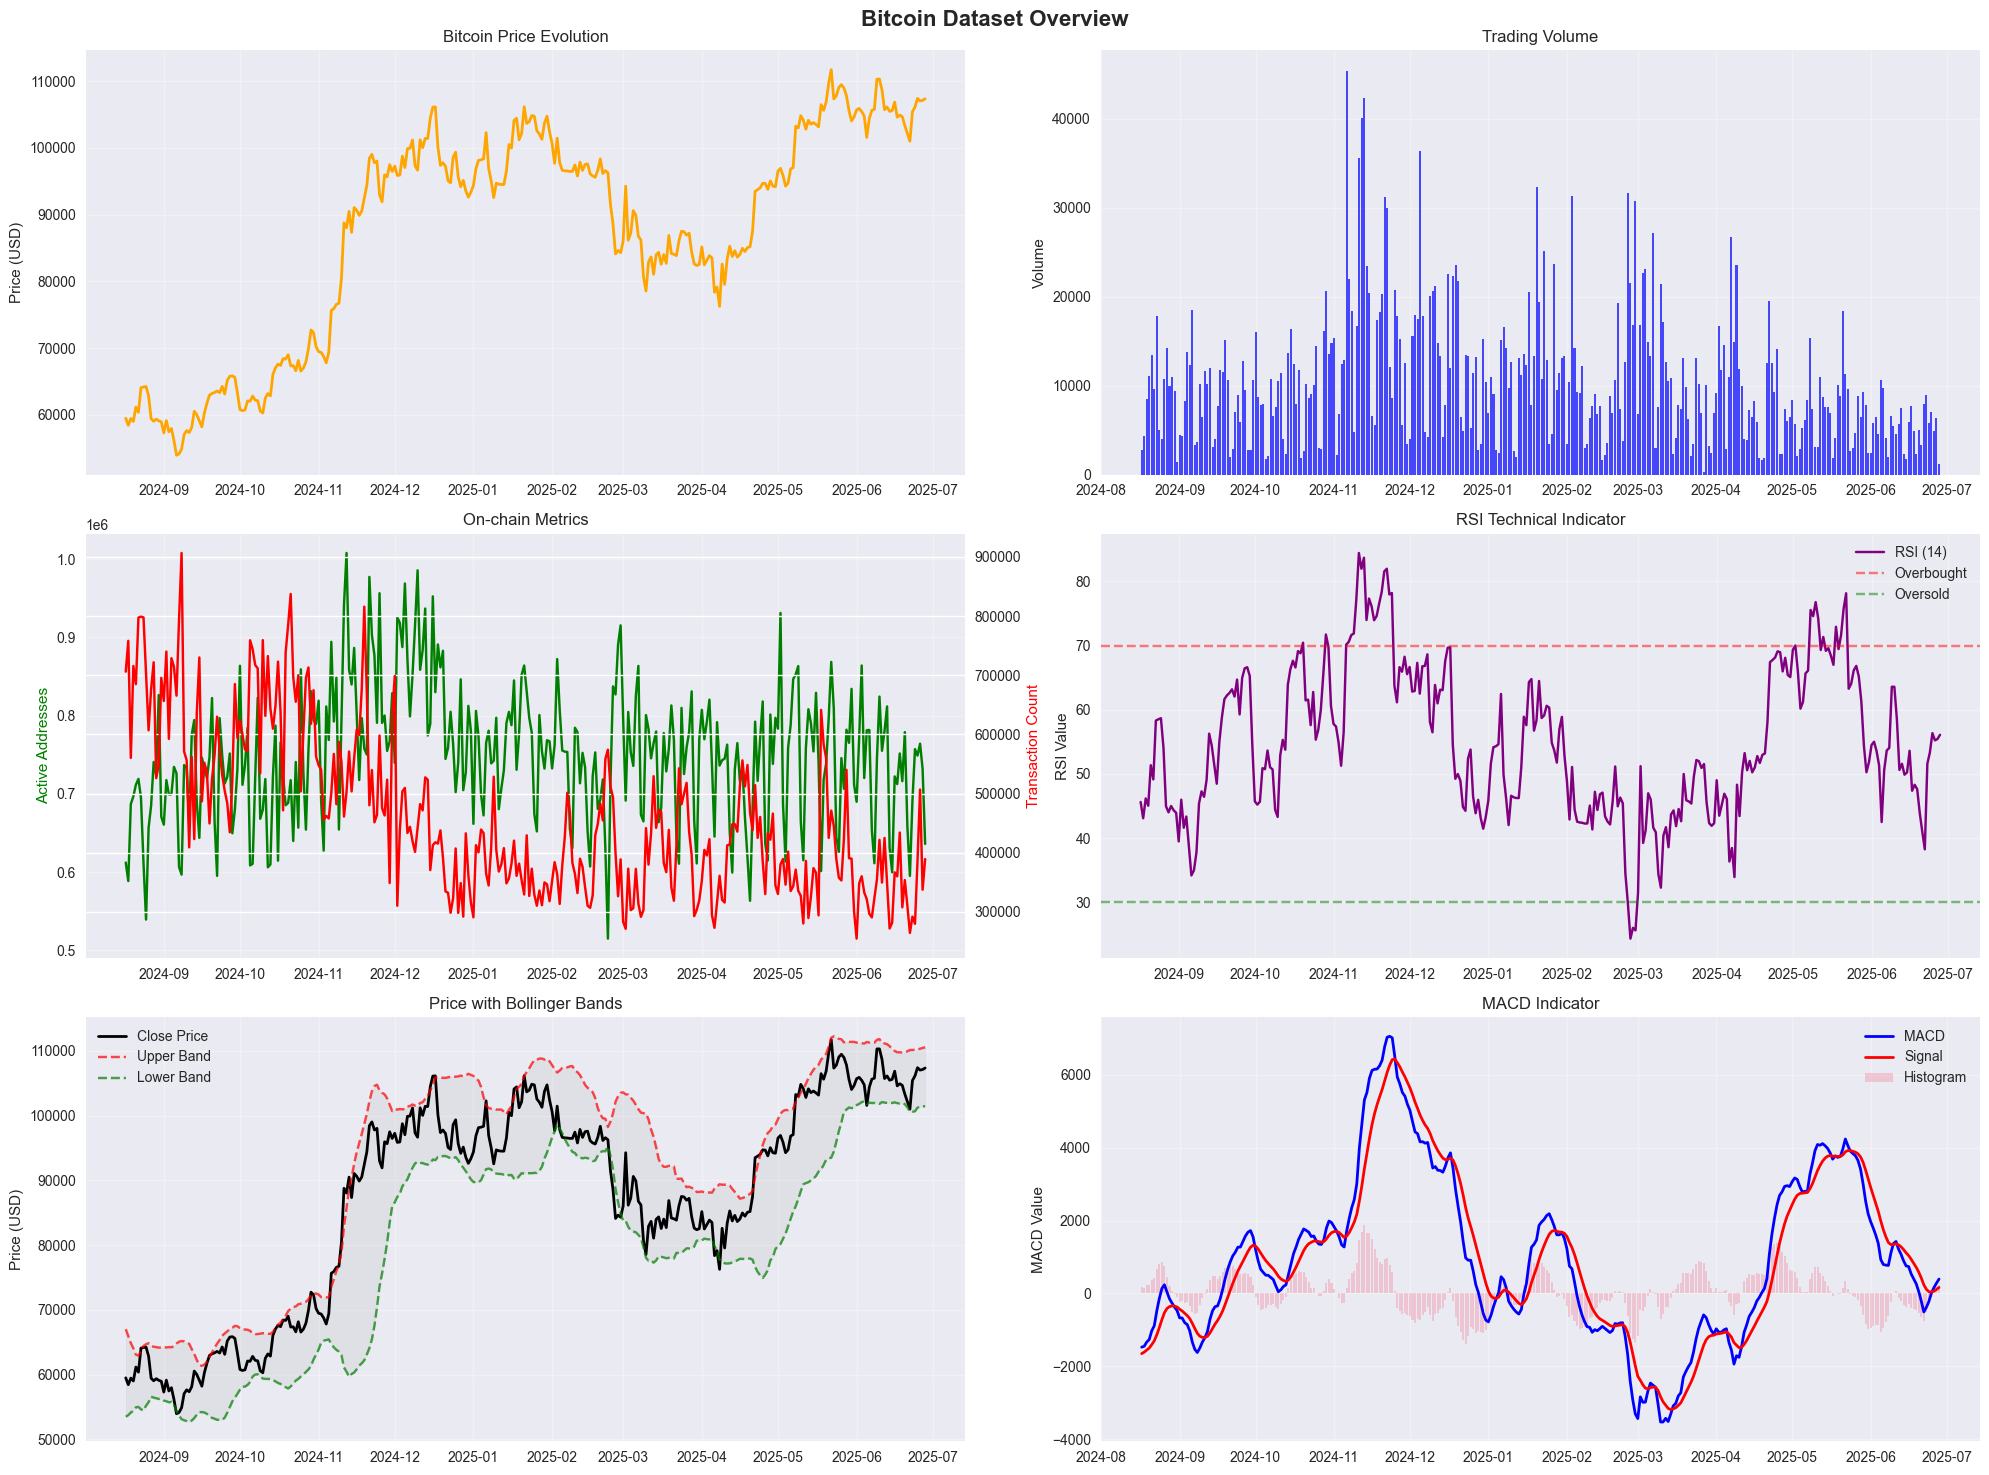

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Bitcoin Dataset Overview', fontsize=16, fontweight='bold')

# 1. Price evolution
axes[0, 0].plot(df.index, df['close'], linewidth=2, color='orange')
axes[0, 0].set_title('Bitcoin Price Evolution')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# 2. Volume analysis
axes[0, 1].bar(df.index, df['volume'], alpha=0.7, color='blue')
axes[0, 1].set_title('Trading Volume')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# 3. On-chain metrics
ax_twin = axes[1, 0].twinx()
axes[1, 0].plot(df.index, df['adractcnt'], 'g-', label='Active Addresses')
ax_twin.plot(df.index, df['txcnt'], 'r-', label='Transaction Count')
axes[1, 0].set_title('On-chain Metrics')
axes[1, 0].set_ylabel('Active Addresses', color='g')
ax_twin.set_ylabel('Transaction Count', color='r')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# 4. Technical indicators
axes[1, 1].plot(df.index, df['rsi_14'], 'purple', label='RSI (14)')
axes[1, 1].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
axes[1, 1].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
axes[1, 1].set_title('RSI Technical Indicator')
axes[1, 1].set_ylabel('RSI Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# 5. Price with Bollinger Bands
axes[2, 0].plot(df.index, df['close'], 'k-', label='Close Price', linewidth=2)
axes[2, 0].plot(df.index, df['bb_upper'], 'r--', alpha=0.7, label='Upper Band')
axes[2, 0].plot(df.index, df['bb_lower'], 'g--', alpha=0.7, label='Lower Band')
axes[2, 0].fill_between(df.index, df['bb_lower'], df['bb_upper'], alpha=0.1, color='gray')
axes[2, 0].set_title('Price with Bollinger Bands')
axes[2, 0].set_ylabel('Price (USD)')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# 6. MACD
axes[2, 1].plot(df.index, df['macd'], 'b-', label='MACD', linewidth=2)
axes[2, 1].plot(df.index, df['macd_signal'], 'r-', label='Signal', linewidth=2)
axes[2, 1].bar(df.index, df['macd'] - df['macd_signal'], alpha=0.3, label='Histogram')
axes[2, 1].set_title('MACD Indicator')
axes[2, 1].set_ylabel('MACD Value')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()


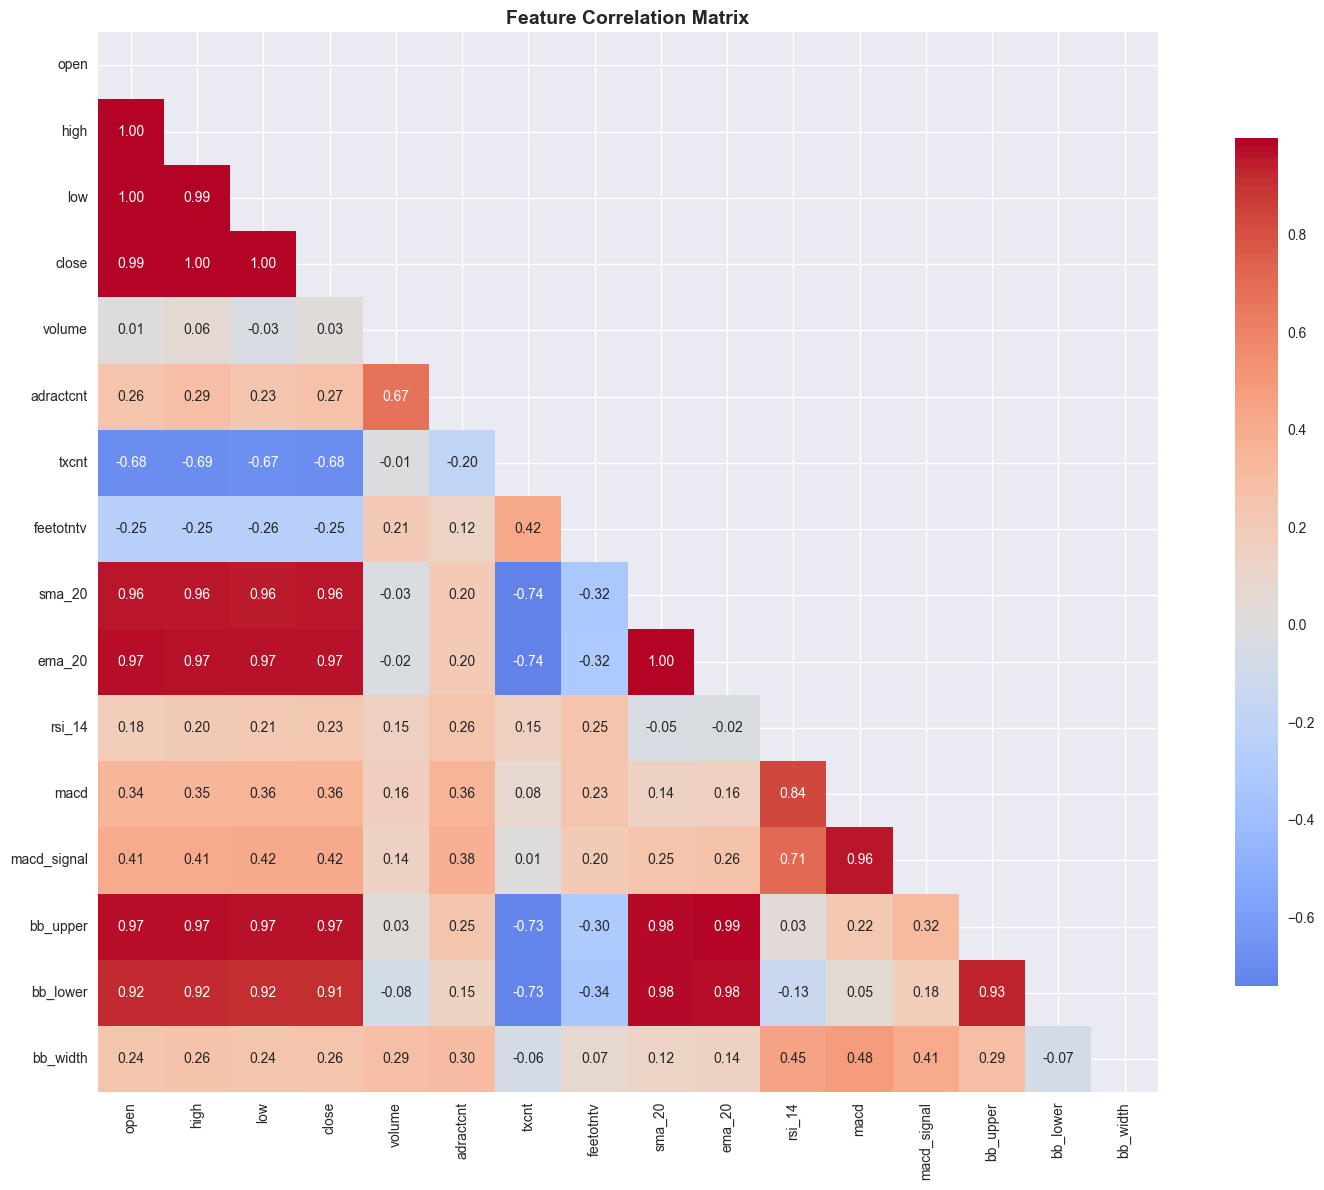


Highly Correlated Feature Pairs (|r| > 0.8):
   open ↔ high: 0.995
   open ↔ low: 0.995
   open ↔ close: 0.991
   open ↔ sma_20: 0.964
   open ↔ ema_20: 0.973
   open ↔ bb_upper: 0.972
   open ↔ bb_lower: 0.923
   high ↔ low: 0.993
   high ↔ close: 0.996
   high ↔ sma_20: 0.962
   high ↔ ema_20: 0.971
   high ↔ bb_upper: 0.973
   high ↔ bb_lower: 0.918
   low ↔ close: 0.995
   low ↔ sma_20: 0.957
   low ↔ ema_20: 0.967
   low ↔ bb_upper: 0.966
   low ↔ bb_lower: 0.916
   close ↔ sma_20: 0.958
   close ↔ ema_20: 0.967
   close ↔ bb_upper: 0.968
   close ↔ bb_lower: 0.914
   sma_20 ↔ ema_20: 0.998
   sma_20 ↔ bb_upper: 0.984
   sma_20 ↔ bb_lower: 0.983
   ema_20 ↔ bb_upper: 0.987
   ema_20 ↔ bb_lower: 0.977
   rsi_14 ↔ macd: 0.841
   macd ↔ macd_signal: 0.964
   bb_upper ↔ bb_lower: 0.934


In [7]:
# Feature correlation analysis
plt.figure(figsize=(16, 12))
correlation_matrix = df[all_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"   {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated features found (|r| > 0.8)")


## 2. Data Preprocessing

We'll prepare the data for deep learning models by:
1. Normalizing features using MinMax scaling
2. Creating sliding window sequences for temporal modeling
3. Splitting data temporally for training, validation, and testing


In [8]:
# Data normalization
from sklearn.preprocessing import StandardScaler

print("Normalizing features...")
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[all_features] = scaler.fit_transform(df[all_features])

print("Feature normalization completed")
print("\nNormalized data sample:")
display(df_scaled[all_features].head())

# Show scaling statistics
print("\nScaling ranges:")
feature_ranges = pd.DataFrame({
    'Original_Min': df[all_features].min(),
    'Original_Max': df[all_features].max(),
    'Scaled_Min': df_scaled[all_features].min(),
    'Scaled_Max': df_scaled[all_features].max()
})
display(feature_ranges.round(4))


Normalizing features...
Feature normalization completed

Normalized data sample:


,open,high,low,close,volume,adractcnt,txcnt,feetotntv,sma_20,ema_20,rsi_14,macd,macd_signal,bb_upper,bb_lower,bb_width
date,,,,,,,,,,,,,,,,
2024-08-17,-1.735853,-1.768673,-1.670835,-1.711774,-1.022690,-1.632328,1.766539,-0.249753,-1.582770,-1.607642,-0.808350,-1.059276,-1.170546,-1.508318,-1.606418,0.089764
2024-08-18,-1.698397,-1.733703,-1.694740,-1.777152,-0.816770,-1.912216,2.146298,-0.237487,-1.608539,-1.619452,-1.027122,-1.049235,-1.152322,-1.572617,-1.591129,-0.130274
2024-08-19,-1.763725,-1.773012,-1.732465,-1.714539,-0.252644,-0.745698,0.703711,-0.055569,-1.629309,-1.624038,-0.760911,-0.998732,-1.127249,-1.636459,-1.566277,-0.374595
2024-08-20,-1.700962,-1.662293,-1.685342,-1.741384,0.085105,-0.628512,1.836661,-0.002811,-1.646600,-1.630803,-0.858199,-0.967703,-1.100742,-1.685152,-1.550234,-0.553161
2024-08-21,-1.727937,-1.638352,-1.671434,-1.608991,0.395449,-0.452935,1.612067,-0.118327,-1.659355,-1.624028,-0.313811,-0.862214,-1.057617,-1.742814,-1.515727,-0.806065



Scaling ranges:


,Original_Min,Original_Max,Scaled_Min,Scaled_Max
open,53950.0000,1.117225e+05,-2.0399,1.5164
high,54847.0000,1.120000e+05,-2.0650,1.4172
low,52530.0000,1.092172e+05,-2.0640,1.4885
close,53950.0100,1.117225e+05,-2.0541,1.5106
volume,261.4992,4.539812e+04,-1.3609,4.6820
adractcnt,515136.0000,1.007782e+06,-2.7853,3.0603
txcnt,254662.0000,9.066550e+05,-1.5235,3.2285
feetotntv,2.6817,1.003452e+02,-0.7269,9.4293
sma_20,57779.5515,1.068093e+05,-1.7358,1.2963
ema_20,57865.0681,1.062757e+05,-1.7678,1.2870


In [9]:
# Create sequences for deep learning
window_size = 30  # 30-day windows for prediction
print(f"Creating sequences with window size: {window_size} days")

X, y = create_sequences(df_scaled, all_features, target, window_size)

print(f"Sequences created successfully!")
print(f"   Input sequences (X): {X.shape}")
print(f"   Target values (y): {y.shape}")
print(f"   Total samples: {len(X)}")

# Explain the sequence structure
print(f"\nSequence Structure:")
print(f"   - Each sample contains {window_size} consecutive days")
print(f"   - Each day has {len(all_features)} features")
print(f"   - Target is the price on day {window_size + 1}")
print(f"   - Total available sequences: {len(X)}")

# Show a sample sequence
print(f"\Sample sequence shape: {X[0].shape}")
print("   Dimensions: (time_steps, features)")


Creating sequences with window size: 30 days
Sequences created successfully!
   Input sequences (X): (286, 30, 16)
   Target values (y): (286,)
   Total samples: 286

Sequence Structure:
   - Each sample contains 30 consecutive days
   - Each day has 16 features
   - Target is the price on day 31
   - Total available sequences: 286
\Sample sequence shape: (30, 16)
   Dimensions: (time_steps, features)


In [10]:
# Temporal data splitting (important for time series!)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(len(X) * train_ratio)
val_size = int(len(X) * val_ratio)
test_size = len(X) - train_size - val_size

# Split data chronologically
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Data Split Summary:")
print(f"   Training:   {len(X_train):3d} samples ({train_ratio:.1%})")
print(f"   Validation: {len(X_val):3d} samples ({val_ratio:.1%})")
print(f"   Testing:    {len(X_test):3d} samples ({test_ratio:.1%})")
print(f"   Total:      {len(X):3d} samples")

# Show date ranges for each split
train_dates = df.index[window_size:window_size + train_size]
val_dates = df.index[window_size + train_size:window_size + train_size + val_size]
test_dates = df.index[window_size + train_size + val_size:]

print("\nDate Ranges:")
print(f"   Training:   {train_dates[0].strftime('%Y-%m-%d')} to {train_dates[-1].strftime('%Y-%m-%d')}")
print(f"   Validation: {val_dates[0].strftime('%Y-%m-%d')} to {val_dates[-1].strftime('%Y-%m-%d')}")
print(f"   Testing:    {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')}")

# Verify no data leakage
print(f"\nTemporal integrity verified - no future data in training!")


Data Split Summary:
   Training:   200 samples (70.0%)
   Validation:  42 samples (15.0%)
   Testing:     44 samples (15.0%)
   Total:      286 samples

Date Ranges:
   Training:   2024-09-16 to 2025-04-03
   Validation: 2025-04-04 to 2025-05-15
   Testing:    2025-05-16 to 2025-06-28

Temporal integrity verified - no future data in training!


## 3. Model Architecture and Training

We'll train three different models:
1. **Baseline CNN-LSTM**: Standard hybrid architecture
2. **Original Attention Model**: Complex multi-head attention (for comparison)
3. **Improved Attention Model**: Simplified attention with better regularization


In [11]:
# Helper function to create data loaders
def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """Create PyTorch data loaders for training."""
    
    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32
)

print("Data loaders created successfully!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")


Data loaders created successfully!
   Training batches: 7
   Validation batches: 2
   Test batches: 2


### 3.1 Baseline CNN-LSTM Model


In [12]:
# Create baseline CNN-LSTM model
print("🏗️ Creating Baseline CNN-LSTM Model...")

baseline_model = CNNLSTM(
    num_features=len(all_features),
    window_size=window_size,
    cnn_filters=64,
    lstm_units=128
)

# Count parameters
total_params = sum(p.numel() for p in baseline_model.parameters())
trainable_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)

print(f"Baseline model created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / (1024**2):.2f} MB (float32)")

# Display model architecture
print("\nModel Architecture:")
print(baseline_model)


🏗️ Creating Baseline CNN-LSTM Model...
Baseline model created!
   Total parameters: 110,913
   Trainable parameters: 110,913
   Model size: 0.42 MB (float32)

Model Architecture:
CNNLSTM(
  (cnn): Sequential(
    (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [13]:
# Train baseline model
print("Training Baseline CNN-LSTM...")

# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = baseline_model.to(device)

# Initialize trainer
trainer_baseline = ModelTrainer(
    model=baseline_model,
    device=device,
    save_dir="../models",
    experiment_name="baseline_cnn_lstm"
)

# Train the model
print("Starting training...")
training_start = datetime.now()

history_baseline = trainer_baseline.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    patience=10,
)

training_time = (datetime.now() - training_start).total_seconds()
print(f"Training completed in {training_time:.1f} seconds")

# Training history summary
print(f"\nTraining Summary:")
print(f"   Best epoch: {history_baseline['best_epoch']}")
print(f"   Best validation loss: {history_baseline['best_val_loss']:.6f}")
print(f"   Final train loss: {history_baseline['train_losses'][-1]:.6f}")
print(f"   Final val loss: {history_baseline['val_losses'][-1]:.6f}")


Training Baseline CNN-LSTM...
Starting training...
Starting training experiment: baseline_cnn_lstm
Device: cpu
Model parameters: 110,913
Results will be saved to: ../models/baseline_cnn_lstm
----------------------------------------------------------------------
Epoch [  1/50] | Train: 0.537186 | Val: 0.433817 | LR: 1.00e-03 | Time: 0.2s
Epoch [  6/50] | Train: 0.036742 | Val: 0.030436 | LR: 1.00e-03 | Time: 1.1s
Epoch [ 11/50] | Train: 0.021366 | Val: 0.027137 | LR: 1.00e-03 | Time: 1.9s
New best model! Val Loss: 0.027067
New best model! Val Loss: 0.026433
New best model! Val Loss: 0.025295
Epoch [ 16/50] | Train: 0.018863 | Val: 0.024791 | LR: 1.00e-03 | Time: 2.8s
New best model! Val Loss: 0.024791
New best model! Val Loss: 0.024393
New best model! Val Loss: 0.023949
Epoch [ 21/50] | Train: 0.018106 | Val: 0.025457 | LR: 1.00e-03 | Time: 3.6s
Epoch [ 26/50] | Train: 0.012891 | Val: 0.026026 | LR: 5.00e-04 | Time: 4.5s

Early stopping at epoch 30
Best validation loss: 0.023949 at epoc

In [14]:
# Evaluate baseline model
print("📏 Evaluating Baseline Model...")

results_baseline = trainer_baseline.evaluate(test_loader, scaler, all_features)
metrics_baseline = results_baseline['metrics']

print("Baseline Model Results:")
print(f"   RMSE: ${metrics_baseline['rmse']:,.2f}")
print(f"   MAE: ${metrics_baseline['mae']:,.2f}")
print(f"   MAPE: {metrics_baseline['mape']:.2f}%")
print(f"   R²: {metrics_baseline['r2']:.4f}")
print(f"   Directional Accuracy: {metrics_baseline['directional_accuracy']:.2f}%")

# Store results for comparison
baseline_results = {
    'model_name': 'Baseline CNN-LSTM',
    'metrics': metrics_baseline,
    'history': history_baseline,
    'training_time': training_time
}


📏 Evaluating Baseline Model...

Evaluating model on test set...
Test Results:
   RMSE: $4,807.17
   MAE: $4,317.51
   MAPE: 4.04%
   R²: -3.3606
   Directional Accuracy: 46.51%
Baseline Model Results:
   RMSE: $4,807.17
   MAE: $4,317.51
   MAPE: 4.04%
   R²: -3.3606
   Directional Accuracy: 46.51%


### 3.2 Original Attention Model (for comparison)


In [15]:
# Create original attention model (known to have overfitting issues)
print("Creating Original Attention Model...")

original_attention_model = CNNLSTMWithAttention(
    num_features=len(all_features),
    cnn_filters=64,
    lstm_units=128,
    attention_heads=4,
    use_feature_attention=True,
    use_temporal_attention=True
)

# Count parameters
total_params_orig = sum(p.numel() for p in original_attention_model.parameters())
trainable_params_orig = sum(p.numel() for p in original_attention_model.parameters() if p.requires_grad)

print(f"Original attention model created!")
print(f"   Total parameters: {total_params_orig:,}")
print(f"   Trainable parameters: {trainable_params_orig:,}")
print(f"   Model size: {total_params_orig * 4 / (1024**2):.2f} MB (float32)")
print(f"   Parameter increase vs baseline: {((total_params_orig - total_params) / total_params) * 100:.1f}%")


Creating Original Attention Model...
Original attention model created!
   Total parameters: 178,905
   Trainable parameters: 178,905
   Model size: 0.68 MB (float32)
   Parameter increase vs baseline: 61.3%


In [16]:
# Train original attention model
print("Training Original Attention Model...")

original_attention_model = original_attention_model.to(device)

trainer_original = ModelTrainer(
    model=original_attention_model,
    device=device,
    save_dir="../models",
    experiment_name="original_attention"
)

# Train with same configuration
print("Starting training...")
training_start = datetime.now()

history_original = trainer_original.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    patience=10,
)

training_time_orig = (datetime.now() - training_start).total_seconds()
print(f"⏱️ Training completed in {training_time_orig:.1f} seconds")

# Evaluate
results_original = trainer_original.evaluate(test_loader, scaler, all_features)
metrics_original = results_original['metrics']

print("Original Attention Model Results:")
print(f"   RMSE: ${metrics_original['rmse']:,.2f}")
print(f"   MAE: ${metrics_original['mae']:,.2f}")
print(f"   MAPE: {metrics_original['mape']:.2f}%")
print(f"   R²: {metrics_original['r2']:.4f}")
print(f"   Directional Accuracy: {metrics_original['directional_accuracy']:.2f}%")

# Store results
original_results = {
    'model_name': 'Original Attention',
    'metrics': metrics_original,
    'history': history_original,
    'training_time': training_time_orig
}


Training Original Attention Model...
Starting training...
Starting training experiment: original_attention
Device: cpu
Model parameters: 178,905
Results will be saved to: ../models/original_attention
----------------------------------------------------------------------
Epoch [  1/50] | Train: 0.660573 | Val: 0.554766 | LR: 1.00e-03 | Time: 0.2s
Epoch [  6/50] | Train: 0.098507 | Val: 0.212813 | LR: 1.00e-03 | Time: 1.5s
Epoch [ 11/50] | Train: 0.053575 | Val: 0.185848 | LR: 1.00e-03 | Time: 2.6s
Epoch [ 16/50] | Train: 0.032557 | Val: 0.206178 | LR: 5.00e-04 | Time: 3.8s

Early stopping at epoch 18
Best validation loss: 0.173376 at epoch 8

Training completed in 4.3s
⏱️ Training completed in 4.6 seconds

Evaluating model on test set...
Test Results:
   RMSE: $6,207.45
   MAE: $5,763.99
   MAPE: 5.39%
   R²: -6.2709
   Directional Accuracy: 44.19%
Original Attention Model Results:
   RMSE: $6,207.45
   MAE: $5,763.99
   MAPE: 5.39%
   R²: -6.2709
   Directional Accuracy: 44.19%


### 3.3 Improved Attention Model (Our Main Contribution)


In [17]:
# Create improved attention model
print("Creating Improved Attention Model...")

improved_attention_model = ImprovedCNNLSTMWithAttention(
    num_features=len(all_features),
    cnn_filters=64,
    lstm_units=128,
    dropout=0.3,
    use_temporal_attention=True
)

# Count parameters
total_params_improved = sum(p.numel() for p in improved_attention_model.parameters())
trainable_params_improved = sum(p.numel() for p in improved_attention_model.parameters() if p.requires_grad)

print(f"Improved attention model created!")
print(f"   Total parameters: {total_params_improved:,}")
print(f"   Trainable parameters: {trainable_params_improved:,}")
print(f"   Model size: {total_params_improved * 4 / (1024**2):.2f} MB (float32)")

print(f"\nParameter Comparison:")
print(f"   Baseline:          {total_params:,} parameters")
print(f"   Original Attention: {total_params_orig:,} parameters (+{((total_params_orig - total_params) / total_params) * 100:.1f}%)")
print(f"   Improved Attention: {total_params_improved:,} parameters (+{((total_params_improved - total_params) / total_params) * 100:.1f}%)")

print(f"\nKey Improvements:")
print(f"   - Simplified attention mechanism")
print(f"   - Better regularization (dropout: 0.3)")
print(f"   - Improved weight initialization")
print(f"   - Reduced complexity for small datasets")


Creating Improved Attention Model...
Improved attention model created!
   Total parameters: 119,234
   Trainable parameters: 119,234
   Model size: 0.45 MB (float32)

Parameter Comparison:
   Baseline:          110,913 parameters
   Original Attention: 178,905 parameters (+61.3%)
   Improved Attention: 119,234 parameters (+7.5%)

Key Improvements:
   - Simplified attention mechanism
   - Better regularization (dropout: 0.3)
   - Improved weight initialization
   - Reduced complexity for small datasets


In [18]:
# Train improved attention model
print("Training Improved Attention Model...")

improved_attention_model = improved_attention_model.to(device)

trainer_improved = ModelTrainer(
    model=improved_attention_model,
    device=device,
    save_dir="../models",
    experiment_name="improved_attention"
)

# Train with optimized configuration
print("Starting training...")
training_start = datetime.now()

history_improved = trainer_improved.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=400,
    learning_rate=0.001,  # Slightly lower learning rate
    patience=200,  # More patience for attention model
    # scheduler_patience=10
)

training_time_improved = (datetime.now() - training_start).total_seconds()
print(f"Training completed in {training_time_improved:.1f} seconds")

# Evaluate
results_improved = trainer_improved.evaluate(test_loader, scaler, all_features)
metrics_improved = results_improved['metrics']

print("Improved Attention Model Results:")
print(f"   RMSE: ${metrics_improved['rmse']:,.2f}")
print(f"   MAE: ${metrics_improved['mae']:,.2f}")
print(f"   MAPE: {metrics_improved['mape']:.2f}%")
print(f"   R²: {metrics_improved['r2']:.4f}")
print(f"   Directional Accuracy: {metrics_improved['directional_accuracy']:.2f}%")

# Store results
improved_results = {
    'model_name': 'Improved Attention',
    'metrics': metrics_improved,
    'history': history_improved,
    'training_time': training_time_improved
}


Training Improved Attention Model...
Starting training...
Starting training experiment: improved_attention
Device: cpu
Model parameters: 119,234
Results will be saved to: ../models/improved_attention
----------------------------------------------------------------------
Epoch [  1/400] | Train: 0.326803 | Val: 0.314598 | LR: 1.00e-03 | Time: 0.2s
Epoch [  6/400] | Train: 0.087213 | Val: 0.132759 | LR: 1.00e-03 | Time: 1.1s
Epoch [ 11/400] | Train: 0.077298 | Val: 0.081838 | LR: 1.00e-03 | Time: 2.0s
New best model! Val Loss: 0.066385
New best model! Val Loss: 0.051334
Epoch [ 16/400] | Train: 0.066281 | Val: 0.050494 | LR: 1.00e-03 | Time: 2.9s
New best model! Val Loss: 0.050494
New best model! Val Loss: 0.041868
Epoch [ 21/400] | Train: 0.051408 | Val: 0.063705 | LR: 1.00e-03 | Time: 3.8s
Epoch [ 26/400] | Train: 0.067028 | Val: 0.106921 | LR: 5.00e-04 | Time: 4.7s
Epoch [ 31/400] | Train: 0.044426 | Val: 0.116751 | LR: 2.50e-04 | Time: 5.6s
Epoch [ 36/400] | Train: 0.061371 | Val: 0.

## 4. Results Analysis and Comparison

Let's analyze and compare the performance of all three models across various metrics.


In [19]:
# Compile all results for comparison
all_results = [baseline_results, original_results, improved_results]

print("🏆 COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in all_results],
    'RMSE ($)': [r['metrics']['rmse'] for r in all_results],
    'MAE ($)': [r['metrics']['mae'] for r in all_results],
    'MAPE (%)': [r['metrics']['mape'] for r in all_results],
    'R²': [r['metrics']['r2'] for r in all_results],
    'Dir. Acc. (%)': [r['metrics']['directional_accuracy'] for r in all_results],
    'Training Time (s)': [r['training_time'] for r in all_results]
})

# Round numeric columns
comparison_df['RMSE ($)'] = comparison_df['RMSE ($)'].round(2)
comparison_df['MAE ($)'] = comparison_df['MAE ($)'].round(2)
comparison_df['MAPE (%)'] = comparison_df['MAPE (%)'].round(2)
comparison_df['R²'] = comparison_df['R²'].round(4)
comparison_df['Dir. Acc. (%)'] = comparison_df['Dir. Acc. (%)'].round(2)
comparison_df['Training Time (s)'] = comparison_df['Training Time (s)'].round(1)

print("📊 Performance Metrics:")
display(comparison_df)

# Calculate improvements
baseline_rmse = baseline_results['metrics']['rmse']
improved_rmse = improved_results['metrics']['rmse']
improvement_percent = ((baseline_rmse - improved_rmse) / baseline_rmse) * 100

print(f"\n🎯 Key Findings:")
print(f"   Best RMSE: {comparison_df['RMSE ($)'].min():,.2f} (${comparison_df.loc[comparison_df['RMSE ($)'].idxmin(), 'Model']})")
print(f"   Improvement over baseline: {improvement_percent:+.1f}%")
print(f"   Best directional accuracy: {comparison_df['Dir. Acc. (%)'].max():.1f}%")

# Identify best model
best_model_idx = comparison_df['RMSE ($)'].idxmin()
best_model = comparison_df.iloc[best_model_idx]['Model']
print(f"   🏆 Overall winner: {best_model}")


🏆 COMPREHENSIVE MODEL COMPARISON
📊 Performance Metrics:


,Model,RMSE ($),MAE ($),MAPE (%),R²,Dir. Acc. (%),Training Time (s)
0,Baseline CNN-LSTM,4807.17,4317.51,4.04,-3.3606,46.51,7.0
1,Original Attention,6207.45,5763.99,5.39,-6.2709,44.19,4.6
2,Improved Attention,11354.81,10841.89,10.19,-23.3289,53.49,39.4



🎯 Key Findings:
   Best RMSE: 4,807.17 ($Baseline CNN-LSTM)
   Improvement over baseline: -136.2%
   Best directional accuracy: 53.5%
   🏆 Overall winner: Baseline CNN-LSTM


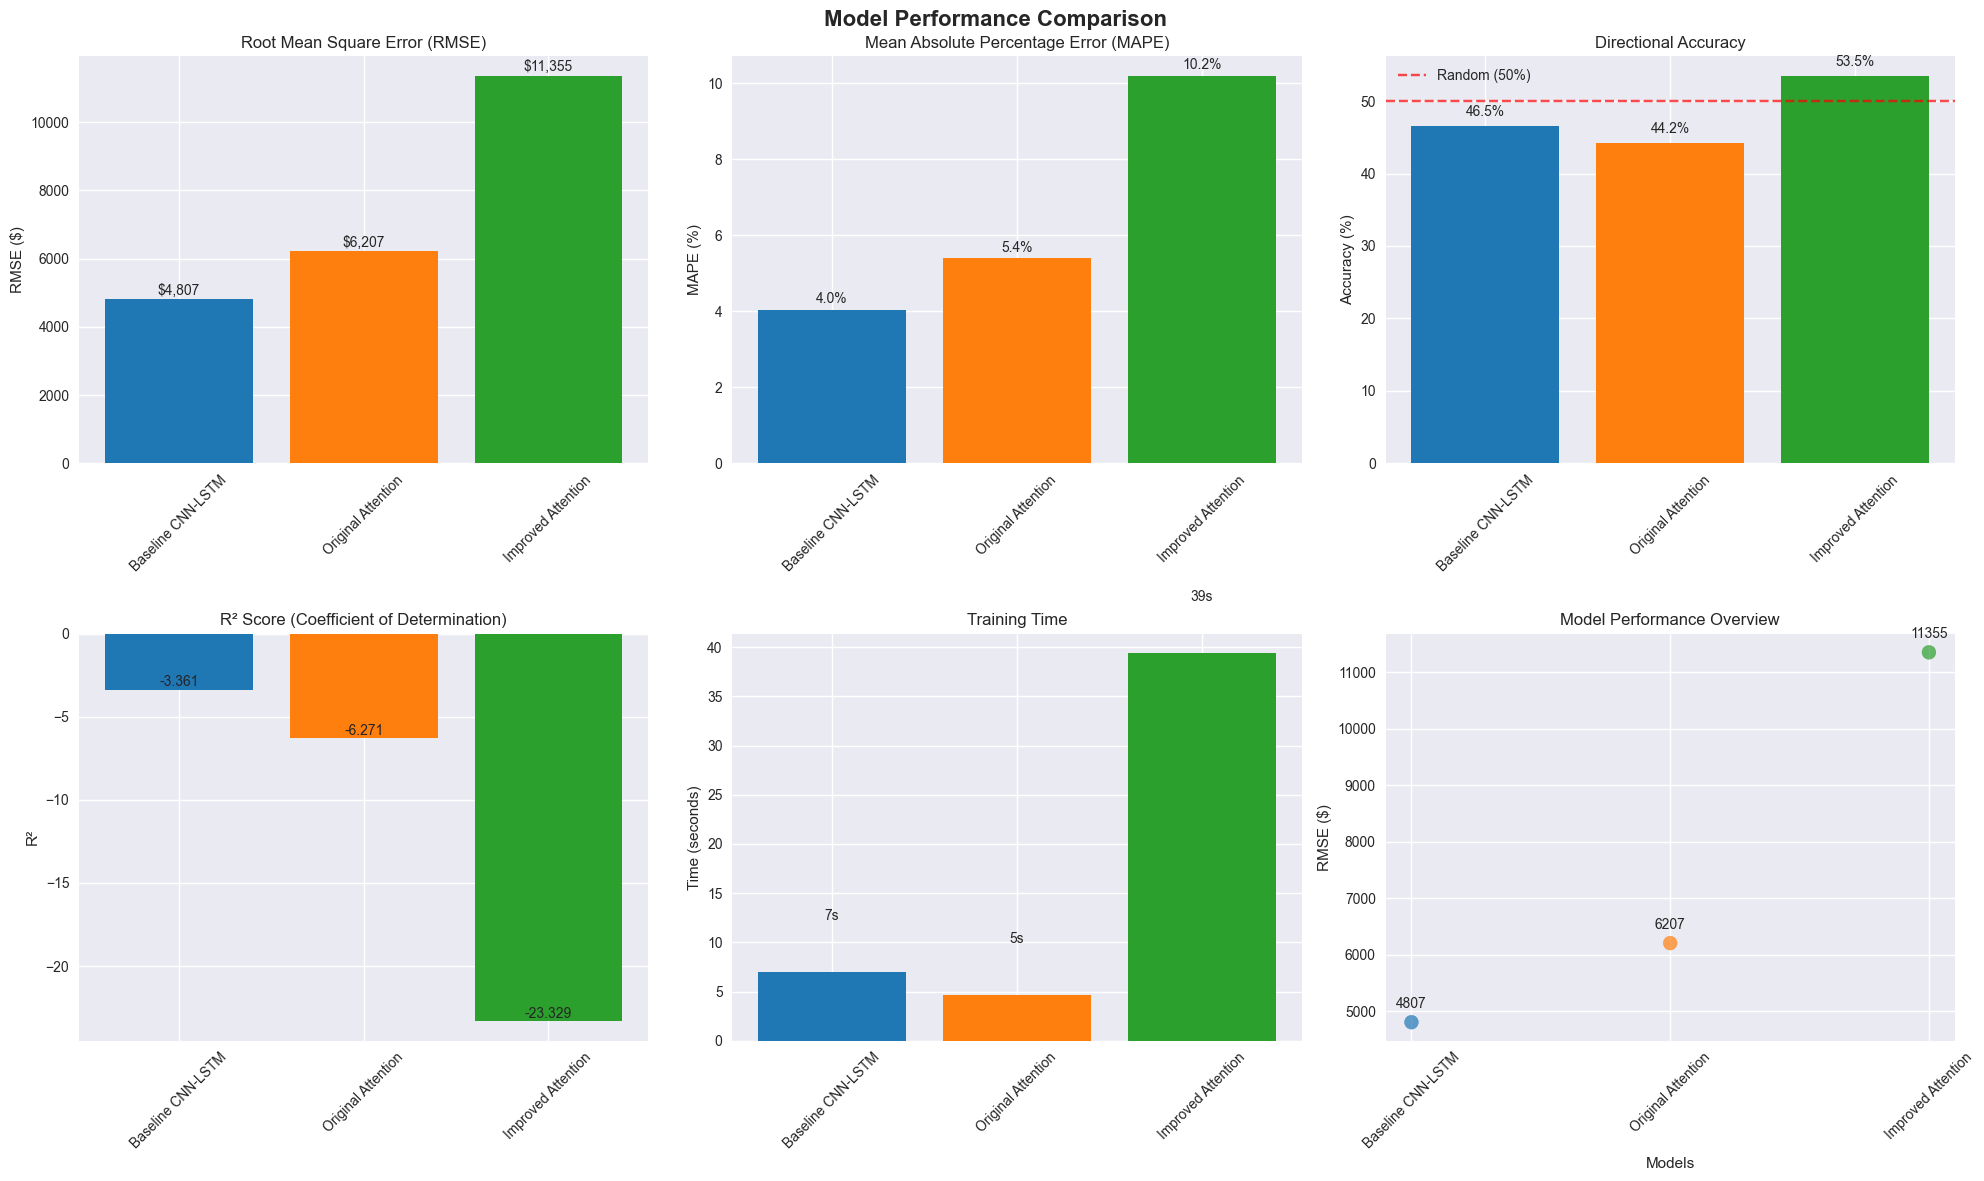

In [20]:
# Visualization of results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

models = comparison_df['Model'].tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. RMSE Comparison
axes[0, 0].bar(models, comparison_df['RMSE ($)'], color=colors)
axes[0, 0].set_title('Root Mean Square Error (RMSE)')
axes[0, 0].set_ylabel('RMSE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['RMSE ($)']):
    axes[0, 0].text(i, v + 50, f'${v:,.0f}', ha='center', va='bottom')

# 2. MAPE Comparison
axes[0, 1].bar(models, comparison_df['MAPE (%)'], color=colors)
axes[0, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['MAPE (%)']):
    axes[0, 1].text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom')

# 3. Directional Accuracy
axes[0, 2].bar(models, comparison_df['Dir. Acc. (%)'], color=colors)
axes[0, 2].set_title('Directional Accuracy')
axes[0, 2].set_ylabel('Accuracy (%)')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
for i, v in enumerate(comparison_df['Dir. Acc. (%)']):
    axes[0, 2].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
axes[0, 2].legend()

# 4. R² Score
axes[1, 0].bar(models, comparison_df['R²'], color=colors)
axes[1, 0].set_title('R² Score (Coefficient of Determination)')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['R²']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 5. Training Time
axes[1, 1].bar(models, comparison_df['Training Time (s)'], color=colors)
axes[1, 1].set_title('Training Time')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[1, 1].text(i, v + 5, f'{v:.0f}s', ha='center', va='bottom')

# 6. Radar chart for normalized metrics
from math import pi

# Normalize metrics for radar chart
metrics_radar = ['RMSE', 'MAPE', 'Dir_Acc', 'R2']
baseline_norm = [1, 1, comparison_df.iloc[0]['Dir. Acc. (%)'], comparison_df.iloc[0]['R²']]
improved_norm = [
    comparison_df.iloc[0]['RMSE ($)'] / comparison_df.iloc[2]['RMSE ($)'],  # Lower is better, so invert
    comparison_df.iloc[0]['MAPE (%)'] / comparison_df.iloc[2]['MAPE (%)'],  # Lower is better, so invert
    comparison_df.iloc[2]['Dir. Acc. (%)'],
    comparison_df.iloc[2]['R²']
]

angles = [n / float(len(metrics_radar)) * 2 * pi for n in range(len(metrics_radar))]
angles += angles[:1]

# Create a simple scatter plot instead of radar chart
axes[1, 2].scatter(range(len(models)), comparison_df['RMSE ($)'], color=colors, s=100, alpha=0.7)
axes[1, 2].set_title('Model Performance Overview')
axes[1, 2].set_xlabel('Models')
axes[1, 2].set_ylabel('RMSE ($)')
axes[1, 2].set_xticks(range(len(models)))
axes[1, 2].set_xticklabels(models, rotation=45)
for i, (model, rmse) in enumerate(zip(models, comparison_df['RMSE ($)'])):
    axes[1, 2].text(i, rmse + 200, f'{rmse:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


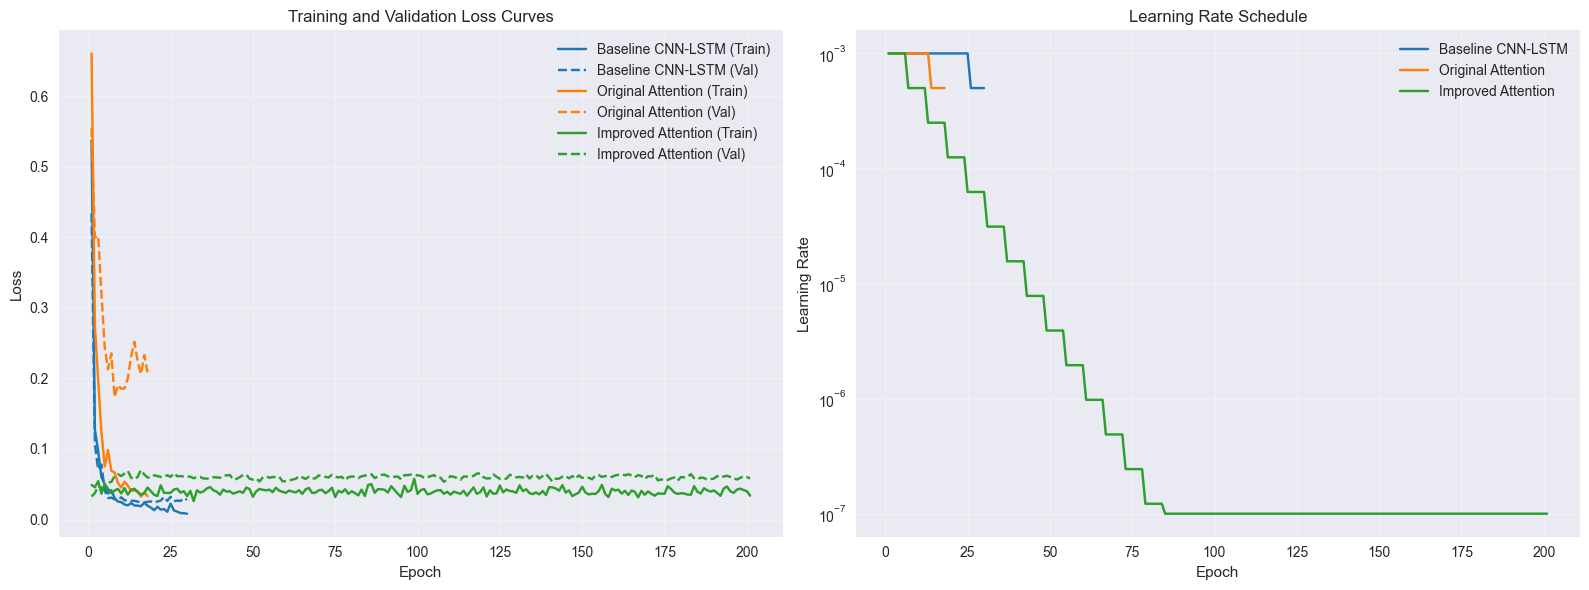

In [44]:
# Training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training loss curves
for i, (result, color) in enumerate(zip(all_results, colors)):
    history = result['history']
    epochs = list(range(1, len(history['train_losses']) + 1))
    axes[0].plot(epochs, history['train_losses'], color=color, label=f"{result['model_name']} (Train)", linestyle='-')
    axes[0].plot(epochs, history['val_losses'], color=color, label=f"{result['model_name']} (Val)", linestyle='--')

axes[0].set_title('Training and Validation Loss Curves')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate curves (if available)
for i, (result, color) in enumerate(zip(all_results, colors)):
    history = result['history']
    if 'learning_rates' in history and len(history['learning_rates']) > 0:
        epochs = list(range(1, len(history['learning_rates']) + 1))
        axes[1].plot(epochs, history['learning_rates'], color=color, label=result['model_name'])

axes[1].set_title('Learning Rate Schedule')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Prediction Analysis

Let's analyze the actual predictions and understand model behavior.


In [21]:
# Generate detailed predictions for the best model (improved attention)
print("📊 Generating Detailed Predictions...")

# Use the improved model for detailed analysis
improved_model = trainer_improved.model
improved_model.eval()

# Get predictions for test set
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    test_predictions_scaled = improved_model(X_test_tensor).cpu().numpy().flatten()

# Transform predictions back to original scale
dummy_features = np.zeros((len(test_predictions_scaled), len(all_features)))
close_idx = all_features.index('close')
dummy_features[:, close_idx] = test_predictions_scaled

# Inverse transform to get actual prices
test_predictions = scaler.inverse_transform(dummy_features)[:, close_idx]

# Get actual test values in original scale
dummy_actual = np.zeros((len(y_test), len(all_features)))
dummy_actual[:, close_idx] = y_test
actual_prices = scaler.inverse_transform(dummy_actual)[:, close_idx]

# Get corresponding dates
test_dates_pred = df.index[window_size + train_size + val_size:window_size + train_size + val_size + len(test_predictions)]

print(f"Generated {len(test_predictions)} predictions")
print(f"   Date range: {test_dates_pred[0].strftime('%Y-%m-%d')} to {test_dates_pred[-1].strftime('%Y-%m-%d')}")

# Create prediction results DataFrame
predictions_df = pd.DataFrame({
    'Date': test_dates_pred,
    'Actual': actual_prices,
    'Predicted': test_predictions,
    'Error': test_predictions - actual_prices,
    'Error_Pct': ((test_predictions - actual_prices) / actual_prices) * 100
})

print("\nSample Predictions:")
display(predictions_df.head(10))


📊 Generating Detailed Predictions...
Generated 44 predictions
   Date range: 2025-05-16 to 2025-06-28

Sample Predictions:


,Date,Actual,Predicted,Error,Error_Pct
0,2025-05-16,103500.03,101116.917128,-2383.112872,-2.302524
1,2025-05-17,103161.07,101057.242743,-2103.827257,-2.039362
2,2025-05-18,106473.46,100849.447905,-5624.012095,-5.282079
3,2025-05-19,105616.18,100677.061247,-4939.118753,-4.676479
4,2025-05-20,106883.24,100578.661399,-6304.578601,-5.898566
5,2025-05-21,109699.54,100876.396724,-8823.143276,-8.043008
6,2025-05-22,111722.53,100477.898687,-11244.631313,-10.064784
7,2025-05-23,107329.61,100022.038896,-7307.571104,-6.808532
8,2025-05-24,107794.01,99384.131368,-8409.878632,-7.801805
9,2025-05-25,109048.68,98774.965575,-10273.714425,-9.421219


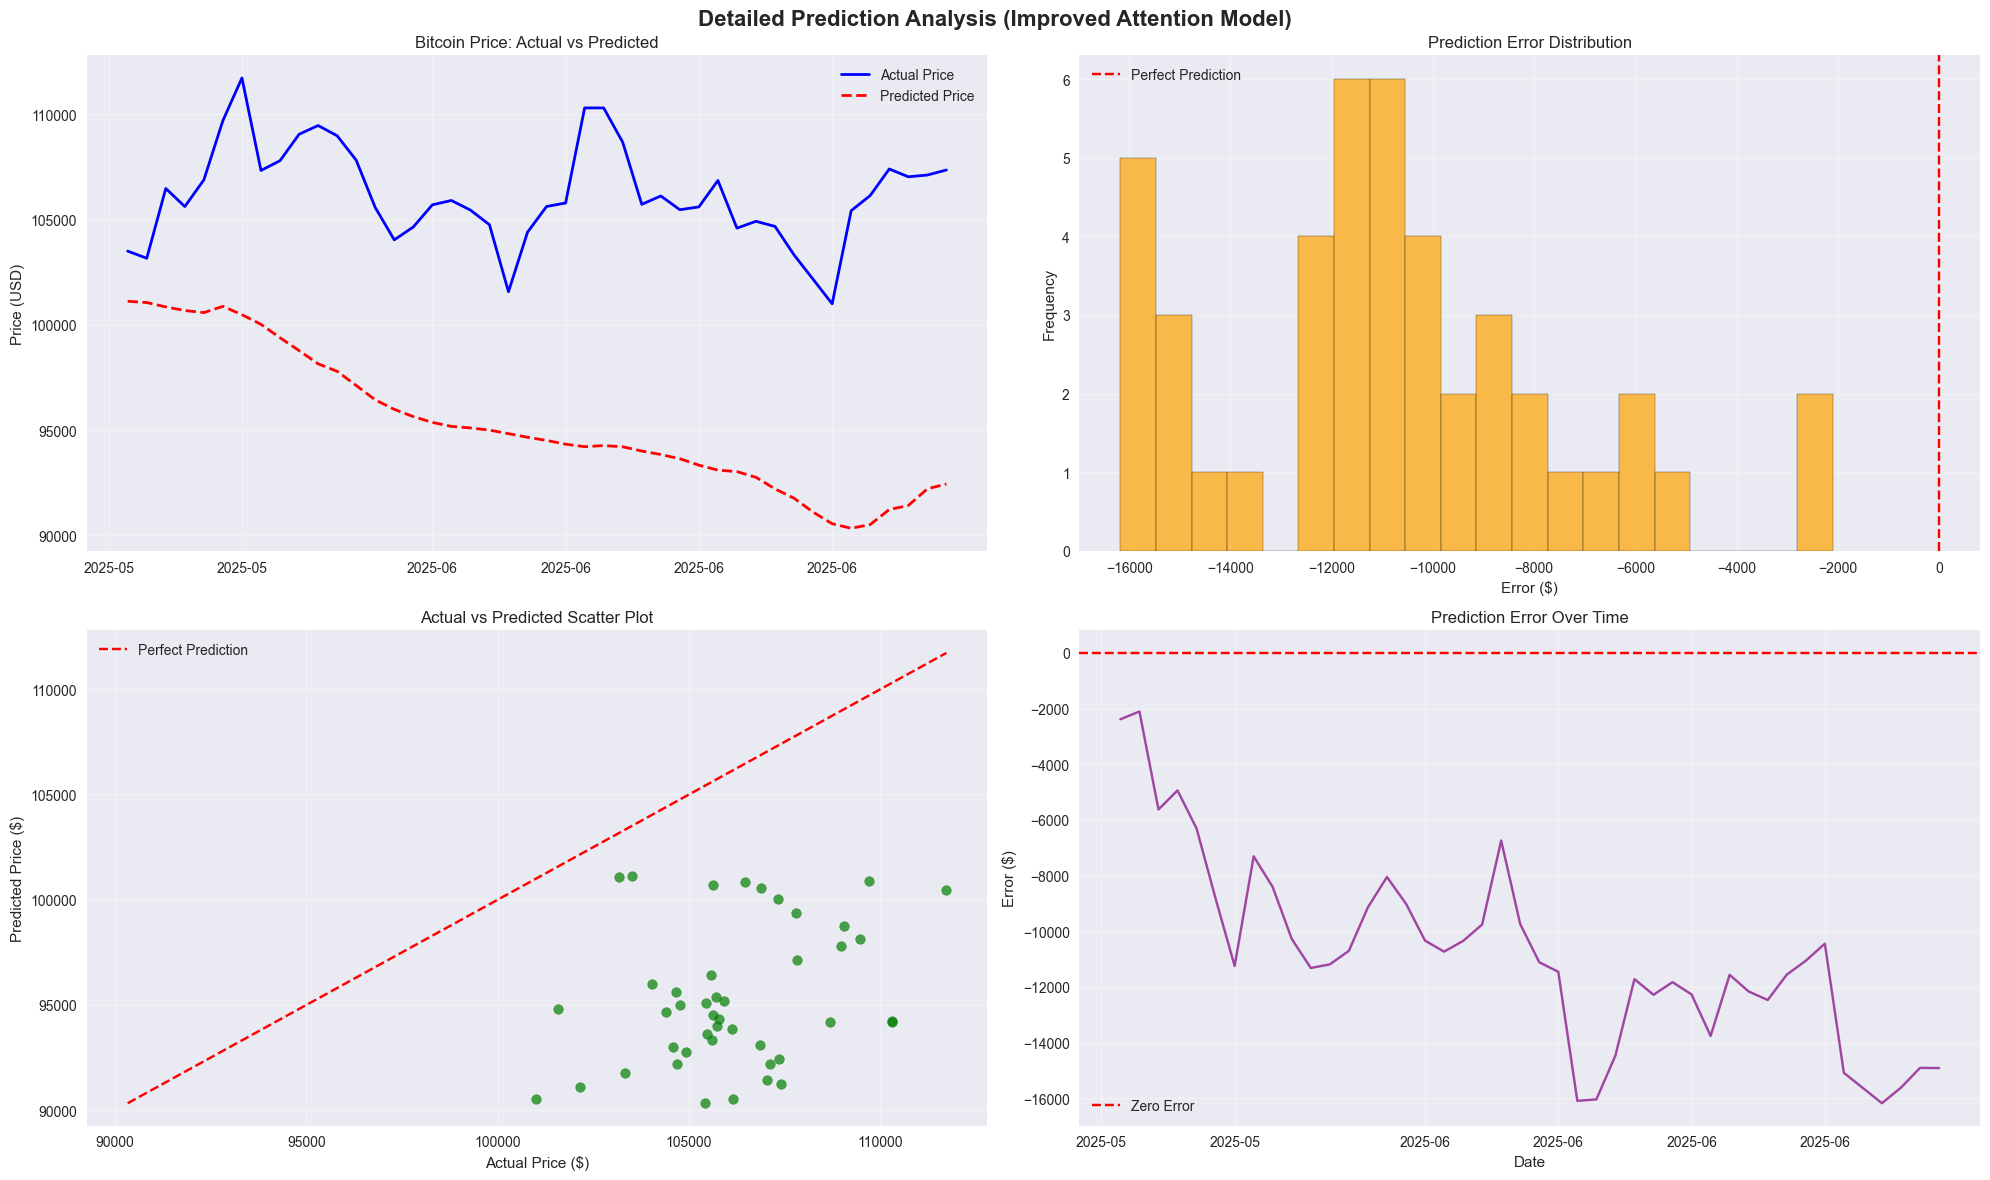

Error Analysis:
   Mean Error: $-10,841.89
   Median Error: $-11,149.11
   Error Std Dev: $3,413.19
   Mean Absolute Error: $10,841.89
   Max Error: $-2,103.83
   Min Error: $-16,174.76

Directional Accuracy: 53.49%


In [22]:
# Detailed prediction analysis and visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Detailed Prediction Analysis (Improved Attention Model)', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted prices over time
axes[0, 0].plot(predictions_df['Date'], predictions_df['Actual'], 'b-', label='Actual Price', linewidth=2)
axes[0, 0].plot(predictions_df['Date'], predictions_df['Predicted'], 'r--', label='Predicted Price', linewidth=2)
axes[0, 0].set_title('Bitcoin Price: Actual vs Predicted')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# 2. Error distribution
axes[0, 1].hist(predictions_df['Error'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
axes[0, 1].set_title('Prediction Error Distribution')
axes[0, 1].set_xlabel('Error ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: Actual vs Predicted
min_price = min(predictions_df['Actual'].min(), predictions_df['Predicted'].min())
max_price = max(predictions_df['Actual'].max(), predictions_df['Predicted'].max())
axes[1, 0].scatter(predictions_df['Actual'], predictions_df['Predicted'], alpha=0.7, color='green')
axes[1, 0].plot([min_price, max_price], [min_price, max_price], 'r--', label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Predicted Scatter Plot')
axes[1, 0].set_xlabel('Actual Price ($)')
axes[1, 0].set_ylabel('Predicted Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Error over time
axes[1, 1].plot(predictions_df['Date'], predictions_df['Error'], 'purple', alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='--', label='Zero Error')
axes[1, 1].set_title('Prediction Error Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Error ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

# Error statistics
print("Error Analysis:")
print(f"   Mean Error: ${predictions_df['Error'].mean():,.2f}")
print(f"   Median Error: ${predictions_df['Error'].median():,.2f}")
print(f"   Error Std Dev: ${predictions_df['Error'].std():,.2f}")
print(f"   Mean Absolute Error: ${predictions_df['Error'].abs().mean():,.2f}")
print(f"   Max Error: ${predictions_df['Error'].max():,.2f}")
print(f"   Min Error: ${predictions_df['Error'].min():,.2f}")

# Directional accuracy analysis
correct_direction = 0
for i in range(1, len(predictions_df)):
    actual_direction = predictions_df.iloc[i]['Actual'] > predictions_df.iloc[i-1]['Actual']
    predicted_direction = predictions_df.iloc[i]['Predicted'] > predictions_df.iloc[i-1]['Predicted']
    if actual_direction == predicted_direction:
        correct_direction += 1

directional_accuracy = (correct_direction / (len(predictions_df) - 1)) * 100
print(f"\nDirectional Accuracy: {directional_accuracy:.2f}%")


## 6. Feature Importance and Attention Analysis

Let's analyze which features the attention mechanism focuses on most.


Analyzing Attention Mechanisms...
Extracted attention weights for 5 samples
   Attention shape: (5, 30)


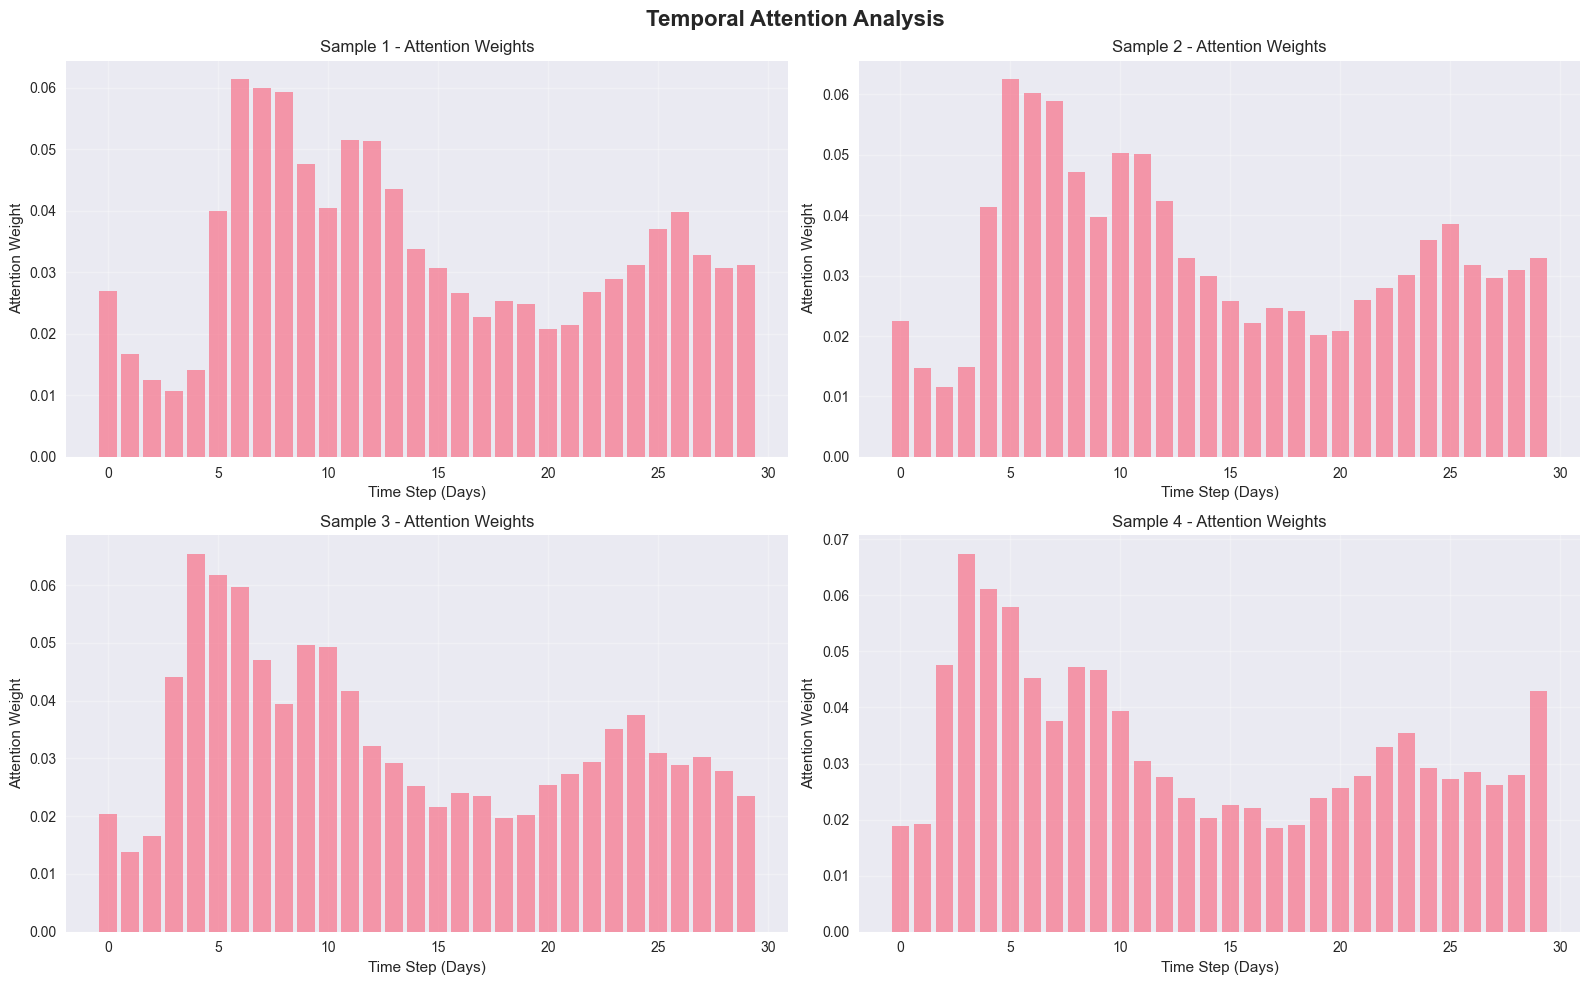

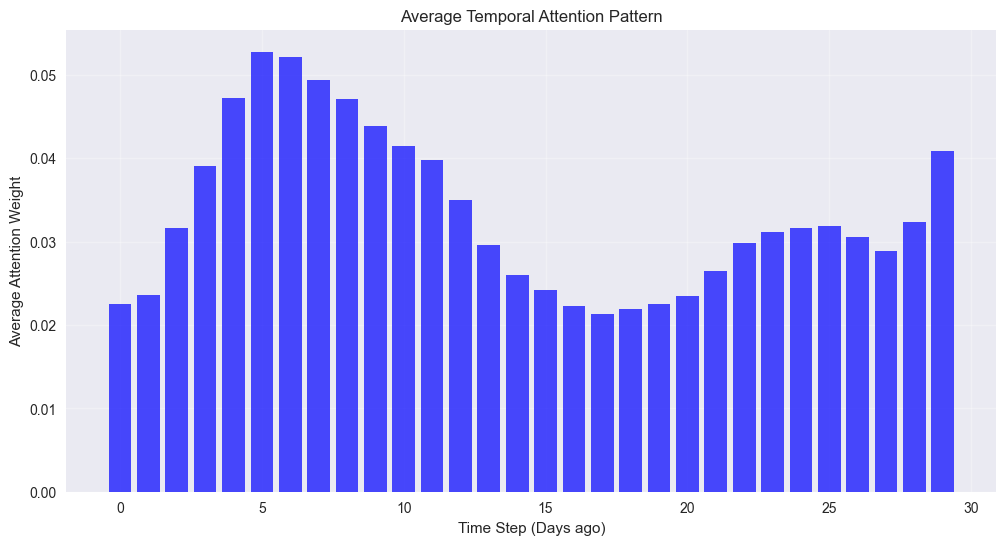

\nAttention Insights:
   Most attended time step: 5 days ago
   Attention concentration: 0.053
   Attention entropy: 3.361
\nFeature Importance Analysis:
Top 10 Most Correlated Features:


,Feature,Correlation_with_Close,Category,Abs_Correlation
3,close,1.000000,Market,1.000000
1,high,0.996367,Market,0.996367
2,low,0.995222,Market,0.995222
0,open,0.991282,Market,0.991282
13,bb_upper,0.968428,Technical,0.968428
9,ema_20,0.967065,Technical,0.967065
8,sma_20,0.957878,Technical,0.957878
14,bb_lower,0.914203,Technical,0.914203
6,txcnt,-0.682597,On-chain,0.682597
12,macd_signal,0.415133,Technical,0.415133


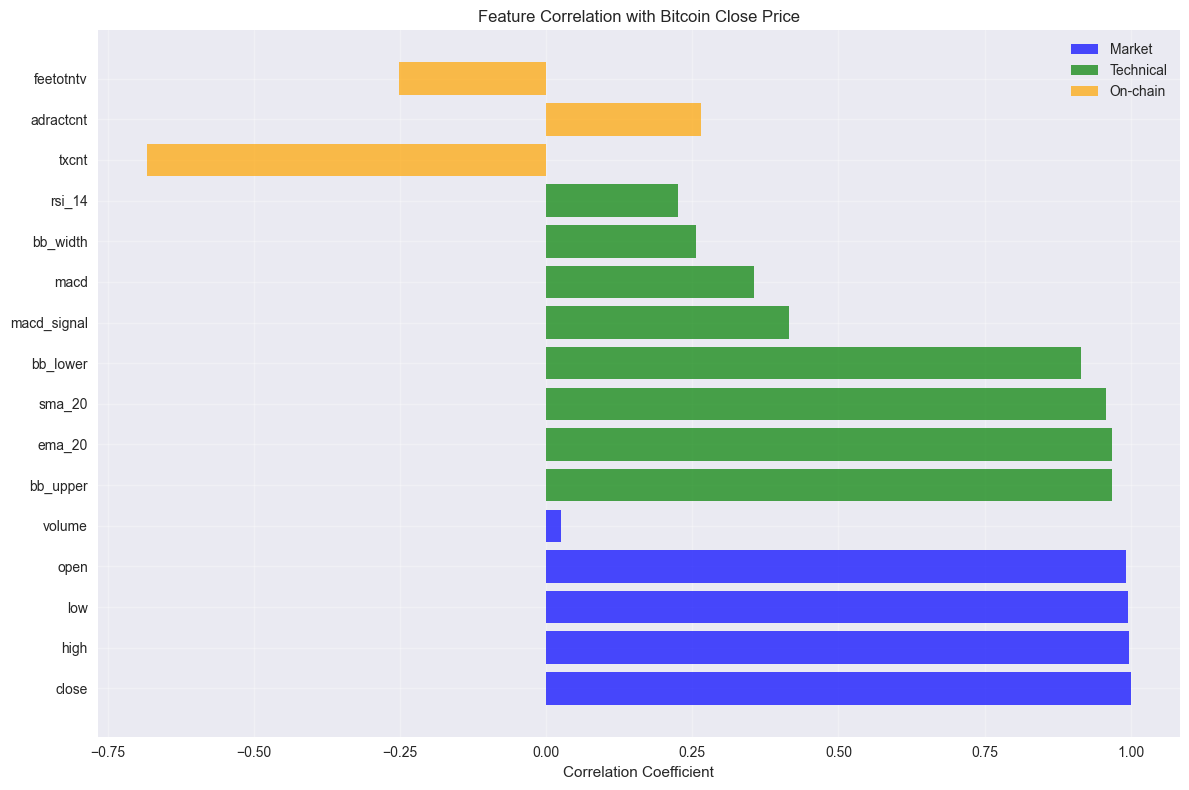

In [23]:
# Attention weights analysis (for models with attention)
print("Analyzing Attention Mechanisms...")

# Extract attention weights from improved model for a sample
improved_model.eval()
sample_input = torch.tensor(X_test[:5], dtype=torch.float32).to(device)

# Get attention weights if available
if hasattr(improved_model, 'temporal_attention'):
    with torch.no_grad():
        # Forward pass through CNN and LSTM
        x = sample_input.permute(0, 2, 1)  # Reshape for CNN
        x = improved_model.cnn(x)
        x = x.permute(0, 2, 1)  # Reshape back for LSTM
        lstm_out, _ = improved_model.lstm(x)
        
        # Get attention weights
        attended_output, attention_weights = improved_model.temporal_attention(lstm_out)
        attention_weights = attention_weights.cpu().numpy()
        
    print(f"Extracted attention weights for {len(attention_weights)} samples")
    print(f"   Attention shape: {attention_weights.shape}")
    
    # Visualize attention weights
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Temporal Attention Analysis', fontsize=16, fontweight='bold')
    
    # Plot attention weights for first few samples
    for i in range(min(4, len(attention_weights))):
        row, col = i // 2, i % 2
        time_steps = list(range(len(attention_weights[i])))
        axes[row, col].bar(time_steps, attention_weights[i], alpha=0.7)
        axes[row, col].set_title(f'Sample {i+1} - Attention Weights')
        axes[row, col].set_xlabel('Time Step (Days)')
        axes[row, col].set_ylabel('Attention Weight')
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Average attention pattern
    avg_attention = np.mean(attention_weights, axis=0)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(avg_attention)), avg_attention, alpha=0.7, color='blue')
    plt.title('Average Temporal Attention Pattern')
    plt.xlabel('Time Step (Days ago)')
    plt.ylabel('Average Attention Weight')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"\\nAttention Insights:")
    max_attention_day = np.argmax(avg_attention)
    print(f"   Most attended time step: {max_attention_day} days ago")
    print(f"   Attention concentration: {np.max(avg_attention):.3f}")
    print(f"   Attention entropy: {-np.sum(avg_attention * np.log(avg_attention + 1e-8)):.3f}")
    
else:
    print("This model doesn't have attention mechanism for analysis")

# Feature correlation with target
print("\\nFeature Importance Analysis:")
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Correlation_with_Close': [df[feat].corr(df['close']) for feat in all_features],
    'Category': ['Market']*5 + ['On-chain']*3 + ['Technical']*8
})

feature_importance['Abs_Correlation'] = feature_importance['Correlation_with_Close'].abs()
feature_importance = feature_importance.sort_values('Abs_Correlation', ascending=False)

print("Top 10 Most Correlated Features:")
display(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
colors_cat = {'Market': 'blue', 'On-chain': 'orange', 'Technical': 'green'}
for category in feature_importance['Category'].unique():
    cat_data = feature_importance[feature_importance['Category'] == category]
    plt.barh(cat_data['Feature'], cat_data['Correlation_with_Close'], 
             alpha=0.7, label=category, color=colors_cat[category])

plt.title('Feature Correlation with Bitcoin Close Price')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
